# Scraping NYT Articles and using NLP methods 
This is to identify and learn about potential EdTech donors!  

In [164]:
# might need to use Beautiful Soup and Pickle for this work too.
import requests
import os
from pprint import pprint

#my usual suspects
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import dateutil
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud, STOPWORDS

In [113]:
nyt_apikey = open('../nyt_apikey.txt','r')

In [114]:
file = nyt_apikey.read().splitlines()

In [115]:
myapikey = file[0]

In [116]:
apikey = os.getenv('NYTIMES_APIKEY', myapikey)

## Look up for current top stories:
https://developer.nytimes.com/docs/top-stories-product/1/overview

In [64]:
section = "education"
query_url = f"https://api.nytimes.com/svc/topstories/v2/{section}.json?api-key={apikey}"

r = requests.get(query_url)
#pprint(r.json())

## Article Search Endpoint
https://developer.nytimes.com/docs/articlesearch-product/1/routes/articlesearch.json/get

In [117]:
query = "education"
begin_date = "20210925" # YYYYMMDD
#filter_query = "\"body:(\"space\") AND glocations:(\"BOSTON\")\""
#filter_query = "\"news_desk:(\"education\") AND body:(\"fund\") AND glocations:(\"NEW YORK CITY\")\""
filter_query = "\"news_desk: (\"education\") AND body:(\"fundraising\") \""
page = "0" # <0-100>
sort = "relevance" # newest, oldest

query_url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?" \
f"q={query}" \
f"&api-key={apikey}" \
f"&begin_date={begin_date}" \
f"&fq={filter_query}" \
f"&page={page}" \
f"&sort={sort}" \

r = requests.get(query_url)

jsonfile = r.json()
#pprint(jsonfile)

In [118]:
jsonfile.keys()

dict_keys(['status', 'copyright', 'response'])

In [119]:
len(jsonfile['response']['docs'])

10

In [120]:
articles = jsonfile['response']['docs']
articles[0].keys()

dict_keys(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section', 'print_page', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'byline', 'type_of_material', '_id', 'word_count', 'uri'])

In [121]:
data = {'abstract': [],
        'web_url': [],
        'lead_paragraph': [],
        'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'keywords': []}

In [122]:
# def get_articles(file):
    
#     article_results = []
    
#     for i in range(len(file)):
#         article_dict = {}
        
#         article_dict['web_url'] = file[i]['web_url']
#         article_dict['abstract'] = file[i]['abstract']
        
#         article_results.append(article_dict)
        
#     return article_results

# list_articles = get_articles(jsonfile['response']['docs'])

In [123]:
for article in articles:
    data['abstract'].append(article['abstract'])
    data['web_url'].append(article['web_url'])
    data['lead_paragraph'].append(article['lead_paragraph'])
    data['headline'].append(article['headline']['main'])
    data['date'].append(article['pub_date'])
    data['doc_type'].append(article['document_type'])
    data['material_type'].append(article['type_of_material'])
    
    keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
    data['keywords'].append(keywords)

In [124]:
df = pd.DataFrame(data) 

In [127]:
df['date'] = pd.to_datetime(df['date'])

In [129]:
df.head(2)

,abstract,web_url,lead_paragraph,headline,date,doc_type,material_type,keywords
0,Some districts have established robust virus t...,https://www.nytimes.com/2021/09/25/health/scho...,"SAN ANTONIO — One recent Thursday, Ciara Brown...","‘I Need an Army’: Across America, Schools Cram...",2021-09-25 13:00:13+00:00,article,News,"[your-feed-science, Tests (Medical), Education..."
1,The rulings were the second and third the last...,https://www.nytimes.com/2021/09/25/us/tennesse...,Two federal judges in Tennessee have dealt blo...,Two more federal judges rule against the Tenne...,2021-09-25 17:24:59+00:00,article,News,"[Special Education, Masks, Coronavirus (2019-n..."


### Cleaning the Data

In [152]:
# combine abstract text
def combine_text(text):
    combined_text = ' '.join(text)
    return combined_text

In [161]:
df['abstract_combined'] = df['abstract'].apply(combine_text)

In [171]:
# make text lowercase, remove text in square brackets, remove punctuations, remove words containing numbers
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[$s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*','',text)
    return text

round1 = lambda x: clean_text_round1(x)

In [172]:
df['abstract_round1'] = df['abstract'].apply(round1)

TypeError: not all arguments converted during string formatting

In [148]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/azadehkeivani/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [149]:
stop_words = set(stopwords.words('english'))

In [150]:
#stop_words = ['the', 'of', 'and', 'is','to','in','a','from','by','that', 'with', 'this', 'as', 'an', 'are','its', 'at', 'for']
my_wc = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(str(df['abstract']))

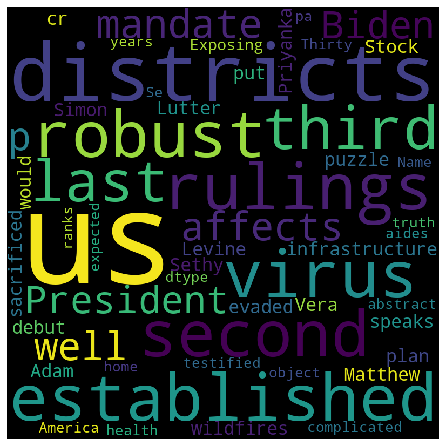

In [151]:
plt.figure(figsize=(8,6), facecolor=None)
plt.imshow(my_wc)
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()